# 常规赛：中文新闻文本标题分类Baseline(PaddleNLP)

# 一.方案介绍

* github地址： [https://github.com/livingbody/Chinese_New_Title_Classification](https://github.com/livingbody/Chinese_New_Title_Classification)
* aistudio地址：[https://aistudio.baidu.com/aistudio/projectdetail/2364933?contributionType=1](https://aistudio.baidu.com/aistudio/projectdetail/2364933?contributionType=1)

## 1.1 赛题简介：

文本分类是借助计算机对文本集(或其他实体或物件)按照一定的分类体系或标准进行自动分类标记。本次比赛为新闻标题文本分类 ，选手需要根据提供的新闻标题文本和类别标签训练一个新闻分类模型，然后对测试集的新闻标题文本进行分类，评价指标上使用Accuracy = 分类正确数量 / 需要分类总数量。同时本次参赛选手需使用飞桨框架和飞桨文本领域核心开发库PaddleNLP，PaddleNLP具备简洁易用的文本领域全流程API、多场景的应用示例、非常丰富的预训练模型，深度适配飞桨框架2.x版本。

比赛传送门：[常规赛：中文新闻文本标题分类](https://aistudio.baidu.com/aistudio/competition/detail/107)

## 1.2 数据介绍：

THUCNews是根据新浪新闻RSS订阅频道2005~2011年间的历史数据筛选过滤生成，包含74万篇新闻文档（2.19 GB），均为UTF-8纯文本格式。本次比赛数据集在原始新浪新闻分类体系的基础上，重新整合划分出14个候选分类类别：财经、彩票、房产、股票、家居、教育、科技、社会、时尚、时政、体育、星座、游戏、娱乐。提供训练数据共832471条。

比赛提供数据集的格式：训练集和验证集格式：原文标题+\t+标签，测试集格式：原文标题。

## 1.3 Baseline思路：

赛题为一道较常规的短文本多分类任务，本项目主要基于PaddleNLP通过预训练模型Robert在提供的训练数据上进行微调完成新闻14分类模型的训练与优化，最后利用训练好的模型对测试数据进行预测并生成提交结果文件。

注意本项目运行需要选择至尊版的GPU环境！若显存不足注意适当改小下batchsize！

BERT前置知识补充：[【原理】经典的预训练模型-BERT](https://aistudio.baidu.com/aistudio/projectdetail/2297740)

![](https://ai-studio-static-online.cdn.bcebos.com/adafc232c53f49258d410e68e3863f1de6747547a9d34ca6b6bf8f4891f4621b)

![](https://ai-studio-static-online.cdn.bcebos.com/b3c5b8ca36e84dcda5a9f1b35b1c6123caf703a1d5b34e1db841bcfdeac2d0d5)

# 二、数据读取与分析

## 1.数据分析

In [ ]:
# 进入比赛数据集存放目录
%cd /home/aistudio/data/data103654/

/home/aistudio/data/data103654


In [ ]:
# 使用pandas读取数据集
import pandas as pd
train = pd.read_table('train.txt', sep='\t',header=None)  # 训练集
dev = pd.read_table('dev.txt', sep='\t',header=None)      # 验证集
test = pd.read_table('test.txt', sep='\t',header=None)    # 测试集

In [ ]:
print(f"train数据集长度： {len(train)}\t dev数据集长度{len(dev)}\t test数据集长度{len(test)}")

train数据集长度： 752471	 dev数据集长度80000	 test数据集长度83599


In [ ]:
# 添加列名便于对数据进行更好处理
train.columns = ["text_a",'label']
dev.columns = ["text_a",'label']
test.columns = ["text_a"]

In [ ]:
# 拼接训练和验证集，便于统计分析
total = pd.concat([train,dev],axis=0)

In [ ]:
#创建字体目录fonts
%cd ~
# !mkdir .fonts

# 复制字体文件到该路径
!cp data/data61659/simhei.ttf .fonts/

/home/aistudio
cp: cannot create regular file '.fonts/': Not a directory


科技    162245
股票    153949
体育    130982
娱乐     92228
时政     62867
社会     50541
教育     41680
财经     36963
家居     32363
游戏     24283
房产     19922
时尚     13335
彩票      7598
星座      3515
Name: label, dtype: int64


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


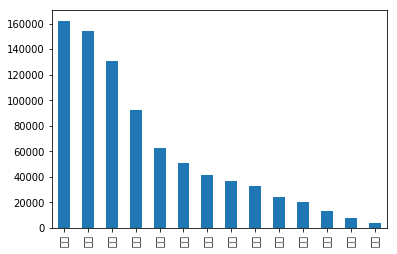

In [ ]:
# 总类别标签分布统计
print(total['label'].value_counts())
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

#指定默认字体
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['font.family']='sans-serif'
#解决负号'-'显示为方块的问题
mpl.rcParams['axes.unicode_minus'] = False

total['label'].value_counts().plot.bar()
plt.show()

In [ ]:
# 最大文本长度
max(total['text_a'].str.len())

48

In [ ]:
# 文本长度统计分析,通过分析可以看出文本较短，最长为48
total['text_a'].map(len).describe()

count    832471.000000
mean         19.388112
std           4.097139
min           2.000000
25%          17.000000
50%          20.000000
75%          23.000000
max          48.000000
Name: text_a, dtype: float64

In [ ]:
# 对测试集的长度统计分析，可以看出在长度上分布与训练数据相近
test['text_a'].map(len).describe()

count    83599.000000
mean        19.815022
std          3.883845
min          3.000000
25%         17.000000
50%         20.000000
75%         23.000000
max         84.000000
Name: text_a, dtype: float64

## 2.保存数据

In [ ]:
# 保存处理后的数据集文件
train.to_csv('train.csv', sep='\t', index=False)  # 保存训练集，格式为text_a,label
dev.to_csv('dev.csv', sep='\t', index=False)      # 保存验证集，格式为text_a,label
test.to_csv('test.csv', sep='\t', index=False)    # 保存测试集，格式为text_a

# 三.基于PaddleNLP构建基线模型

![](https://ai-studio-static-online.cdn.bcebos.com/75742955d912447c948bb679994a09039af5f85cfb554715be56c970db5ec3f6)

## 1 PaddleNLP环境准备

In [ ]:
# 下载最新版本的paddlenlp
# !pip install --upgrade paddlenlp

In [ ]:
# 导入所需的第三方库
import math
import numpy as np
import os
import collections
from functools import partial
import random
import time
import inspect
import importlib
from tqdm import tqdm
import paddle
import paddle.nn as nn
import paddle.nn.functional as F
from paddle.io import IterableDataset
from paddle.utils.download import get_path_from_url
# 导入paddlenlp所需的相关包
import paddlenlp as ppnlp
from paddlenlp.data import JiebaTokenizer, Pad, Stack, Tuple, Vocab
from paddlenlp.datasets import MapDataset
from paddle.dataset.common import md5file
from paddlenlp.datasets import DatasetBuilder

## 2.数据集定义

In [ ]:
# 定义要进行分类的14个类别
label_list=list(train.label.unique())
print(label_list)

['科技', '体育', '时政', '股票', '娱乐', '教育', '家居', '财经', '房产', '社会', '游戏', '彩票', '星座', '时尚']


In [ ]:
# id 到 label转换
id_label_dict={}
for i in range(0,len(label_list)):
    id_label_dict[i]=label_list[i]
print(id_label_dict)
#################################################
# label到id转换
label_id_dict={}
for i in range(0,len(label_list)):
    label_id_dict[label_list[i]]=i
print(label_id_dict)

{0: '科技', 1: '体育', 2: '时政', 3: '股票', 4: '娱乐', 5: '教育', 6: '家居', 7: '财经', 8: '房产', 9: '社会', 10: '游戏', 11: '彩票', 12: '星座', 13: '时尚'}
{'科技': 0, '体育': 1, '时政': 2, '股票': 3, '娱乐': 4, '教育': 5, '家居': 6, '财经': 7, '房产': 8, '社会': 9, '游戏': 10, '彩票': 11, '星座': 12, '时尚': 13}


In [ ]:
def read(pd_data):
    for index, item in pd_data.iterrows():       
        yield {'text_a': item['text_a'], 'label': label_id_dict[item['label']]}

In [ ]:
# 训练集、测试集
from paddle.io import Dataset, Subset
from paddlenlp.datasets import MapDataset
from paddlenlp.datasets import load_dataset

train_dataset = load_dataset(read, pd_data=train,lazy=False)
dev_dataset = load_dataset(read, pd_data=dev,lazy=False)

In [ ]:
for i in range(5):
    print(train_dataset[i])

{'text_a': '网易第三季度业绩低于分析师预期', 'label': 0}
{'text_a': '巴萨1年前地狱重现这次却是天堂 再赴魔鬼客场必翻盘', 'label': 1}
{'text_a': '美国称支持向朝鲜提供紧急人道主义援助', 'label': 2}
{'text_a': '增资交银康联 交行夺参股险商首单', 'label': 3}
{'text_a': '午盘：原材料板块领涨大盘', 'label': 3}


## 3加载预训练模型

In [ ]:
# 此次使用在中文领域效果较优的roberta-wwm-ext-large模型，预训练模型一般“大力出奇迹”，选用大的预训练模型可以取得比base模型更优的效果
MODEL_NAME = "roberta-wwm-ext-large"
# 只需指定想要使用的模型名称和文本分类的类别数即可完成Fine-tune网络定义，通过在预训练模型后拼接上一个全连接网络（Full Connected）进行分类
model = ppnlp.transformers.RobertaForSequenceClassification.from_pretrained(MODEL_NAME, num_classes=14) # 此次分类任务为14分类任务，故num_classes设置为14
# 定义模型对应的tokenizer，tokenizer可以把原始输入文本转化成模型model可接受的输入数据格式。需注意tokenizer类要与选择的模型相对应，具体可以查看PaddleNLP相关文档
tokenizer = ppnlp.transformers.RobertaTokenizer.from_pretrained(MODEL_NAME)

PaddleNLP不仅支持RoBERTa预训练模型，还支持ERNIE、BERT、Electra等预训练模型。具体可以查看：[PaddleNLP模型](https://paddlenlp.readthedocs.io/zh/latest/source/paddlenlp.transformers.html)

下表汇总了目前PaddleNLP支持的各类预训练模型。用户可以使用PaddleNLP提供的模型，完成问答、序列分类、token分类等任务。同时还提供了22种预训练的参数权重供用户使用，其中包含了11种中文语言模型的预训练权重。

| Model | Tokenizer| Supported Task| Model Name|
|---|---|---|---|
| [BERT](https://arxiv.org/abs/1810.04805) | BertTokenizer|BertModel<br> BertForQuestionAnswering<br> BertForSequenceClassification<br>BertForTokenClassification| `bert-base-uncased`<br> `bert-large-uncased` <br>`bert-base-multilingual-uncased` <br>`bert-base-cased`<br> `bert-base-chinese`<br> `bert-base-multilingual-cased`<br> `bert-large-cased`<br> `bert-wwm-chinese`<br> `bert-wwm-ext-chinese` |
|[ERNIE](https://arxiv.org/abs/1904.09223)|ErnieTokenizer<br>ErnieTinyTokenizer|ErnieModel<br> ErnieForQuestionAnswering<br> ErnieForSequenceClassification<br> ErnieForTokenClassification| `ernie-1.0`<br> `ernie-tiny`<br> `ernie-2.0-en`<br> `ernie-2.0-large-en`|
|[RoBERTa](https://arxiv.org/abs/1907.11692)|RobertaTokenizer| RobertaModel<br>RobertaForQuestionAnswering<br>RobertaForSequenceClassification<br>RobertaForTokenClassification| `roberta-wwm-ext`<br> `roberta-wwm-ext-large`<br> `rbt3`<br> `rbtl3`|
|[ELECTRA](https://arxiv.org/abs/2003.10555) |ElectraTokenizer| ElectraModel<br>ElectraForSequenceClassification<br>ElectraForTokenClassification<br>|`electra-small`<br> `electra-base`<br> `electra-large`<br> `chinese-electra-small`<br> `chinese-electra-base`<br>|

注：其中中文的预训练模型有 `bert-base-chinese, bert-wwm-chinese, bert-wwm-ext-chinese, ernie-1.0, ernie-tiny, roberta-wwm-ext, roberta-wwm-ext-large, rbt3, rbtl3, chinese-electra-base, chinese-electra-small` 等。

![](https://ai-studio-static-online.cdn.bcebos.com/0e7623086e034228a1f7e9db834536486ba42d00823749f3bb083f3e25cdf7d9)

## 4.定义数据处理函数

In [ ]:
# 定义数据加载和处理函数
def convert_example(example, tokenizer, max_seq_length=128, is_test=False):
    qtconcat = example["text_a"]
    encoded_inputs = tokenizer(text=qtconcat, max_seq_len=max_seq_length)  # tokenizer处理为模型可接受的格式 
    input_ids = encoded_inputs["input_ids"]
    token_type_ids = encoded_inputs["token_type_ids"]

    if not is_test:
        label = np.array([example["label"]], dtype="int64")
        return input_ids, token_type_ids, label
    else:
        return input_ids, token_type_ids

# 定义数据加载函数dataloader
def create_dataloader(dataset,
                      mode='train',
                      batch_size=1,
                      batchify_fn=None,
                      trans_fn=None):
    if trans_fn:
        dataset = dataset.map(trans_fn)

    shuffle = True if mode == 'train' else False
    # 训练数据集随机打乱，测试数据集不打乱
    if mode == 'train':
        batch_sampler = paddle.io.DistributedBatchSampler(
            dataset, batch_size=batch_size, shuffle=shuffle)
    else:
        batch_sampler = paddle.io.BatchSampler(
            dataset, batch_size=batch_size, shuffle=shuffle)

    return paddle.io.DataLoader(
        dataset=dataset,
        batch_sampler=batch_sampler,
        collate_fn=batchify_fn,
        return_list=True)

# 四、模型训练

## 1.超参设置

In [ ]:
# 参数设置：
# 批处理大小，显存如若不足的话可以适当改小该值  
batch_size = 360
# 文本序列最大截断长度，需要根据文本具体长度进行确定，最长不超过512。 通过文本长度分析可以看出文本长度最大为48，故此处设置为48
max_seq_length = max(total['text_a'].str.len())

## 2.数据处理

In [ ]:
# 将数据处理成模型可读入的数据格式
trans_func = partial(
    convert_example,
    tokenizer=tokenizer,
    max_seq_length=max_seq_length)

batchify_fn = lambda samples, fn=Tuple(
    Pad(axis=0, pad_val=tokenizer.pad_token_id),  # input_ids
    Pad(axis=0, pad_val=tokenizer.pad_token_type_id),  # token_type_ids
    Stack()  # labels
): [data for data in fn(samples)]

# 训练集迭代器
train_data_loader = create_dataloader(
    train_dataset,
    mode='train',
    batch_size=batch_size,
    batchify_fn=batchify_fn,
    trans_fn=trans_func)

# 验证集迭代器
dev_data_loader = create_dataloader(
    dev_dataset,
    mode='dev',
    batch_size=batch_size,
    batchify_fn=batchify_fn,
    trans_fn=trans_func)

## 3.设置评价指标

适用于BERT这类Transformer模型的学习率为warmup的动态学习率。

In [ ]:
# 定义超参，loss，优化器等
from paddlenlp.transformers import LinearDecayWithWarmup


# 定义训练过程中的最大学习率
learning_rate = 4e-5
# 训练轮次
epochs = 32
# 学习率预热比例
warmup_proportion = 0.1
# 权重衰减系数，类似模型正则项策略，避免模型过拟合
weight_decay = 0.01

num_training_steps = len(train_data_loader) * epochs
lr_scheduler = LinearDecayWithWarmup(learning_rate, num_training_steps, warmup_proportion)

# AdamW优化器
optimizer = paddle.optimizer.AdamW(
    learning_rate=lr_scheduler,
    parameters=model.parameters(),
    weight_decay=weight_decay,
    apply_decay_param_fun=lambda x: x in [
        p.name for n, p in model.named_parameters()
        if not any(nd in n for nd in ["bias", "norm"])
    ])

criterion = paddle.nn.loss.CrossEntropyLoss()  # 交叉熵损失函数
metric = paddle.metric.Accuracy()              # accuracy评价指标

## 4.模型评估

ps：模型训练时，可以通过在终端输入nvidia-smi命令或者通过点击底部‘性能监控’选项查看显存的占用情况，适当调整好batchsize，防止出现显存不足意外暂停的情况。

In [ ]:
# 定义模型训练验证评估函数
@paddle.no_grad()
def evaluate(model, criterion, metric, data_loader):
    model.eval()
    metric.reset()
    losses = []
    for batch in data_loader:
        input_ids, token_type_ids, labels = batch
        logits = model(input_ids, token_type_ids)
        loss = criterion(logits, labels)
        losses.append(loss.numpy())
        correct = metric.compute(logits, labels)
        metric.update(correct)
        accu = metric.accumulate()
    print("eval loss: %.8f, accu: %.8f" % (np.mean(losses), accu))  # 输出验证集上评估效果
    model.train()
    metric.reset()
    return  np.mean(losses), accu  # 返回准确率

## 5.模型训练

In [ ]:
# 固定随机种子便于结果的复现
# seed = 1024
seed = 512
random.seed(seed)
np.random.seed(seed)
paddle.seed(seed)
%cd ~

/home/aistudio


ps:模型训练时可以通过在终端输入nvidia-smi命令或通过底部右下的性能监控选项查看显存占用情况，显存不足的话要适当调整好batchsize的值。

In [ ]:
# 模型训练：
import paddle.nn.functional as F
from visualdl import LogWriter

save_dir='./'
writer = LogWriter("./log")
tic_train = time.time()
global_step = 0
best_val_acc=0
tic_train = time.time()
accu=0

for epoch in range(1, epochs + 1):
    for step, batch in enumerate(train_data_loader, start=1):
        input_ids, segment_ids, labels = batch
        logits = model(input_ids, segment_ids)
        loss = criterion(logits, labels)
        probs = F.softmax(logits, axis=1)
        correct = metric.compute(probs, labels)
        metric.update(correct)
        acc = metric.accumulate()
        global_step+=1
        if global_step % 40 == 0:
            print(
                "global step %d, epoch: %d, batch: %d, loss: %.8f, accu: %.8f, speed: %.2f step/s"
                % (global_step, epoch, step, loss, acc,
                    40 / (time.time() - tic_train)))
            tic_train = time.time()

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.clear_grad()
        
        # 大于100次再eval，或者再大一点eval，太小没有eval的意义
        if global_step % 200 == 0 and global_step>=3000:
            # 评估当前训练的模型
            eval_loss, eval_accu = evaluate(model, criterion, metric, dev_data_loader)
            print("eval  on dev  loss: {:.8}, accu: {:.8}".format(eval_loss, eval_accu))
            # 加入eval日志显示
            writer.add_scalar(tag="eval/loss", step=global_step, value=eval_loss)
            writer.add_scalar(tag="eval/acc", step=global_step, value=eval_accu)
            # 加入train日志显示
            writer.add_scalar(tag="train/loss", step=global_step, value=loss)
            writer.add_scalar(tag="train/acc", step=global_step, value=acc)
            save_dir = "best_checkpoint"
            # 加入保存       
            if eval_accu>best_val_acc:
                if not os.path.exists(save_dir):
                    os.mkdir(save_dir)
                best_val_acc=eval_accu
                print(f"模型保存在 {global_step} 步， 最佳eval准确度为{best_val_acc:.8f}！")
                save_param_path = os.path.join(save_dir, 'best_model.pdparams')
                paddle.save(model.state_dict(), save_param_path)
                fh = open('best_checkpoint/best_model.txt', 'w', encoding='utf-8')
                fh.write(f"模型保存在 {global_step} 步， 最佳eval准确度为{best_val_acc:.8f}！")
                fh.close()

tokenizer.save_pretrained(save_dir)

global step 40, epoch: 1, batch: 40, loss: 2.66168261, accu: 0.03826389, speed: 0.61 step/s
global step 80, epoch: 1, batch: 80, loss: 2.55217147, accu: 0.06201389, speed: 0.60 step/s
global step 120, epoch: 1, batch: 120, loss: 2.35012722, accu: 0.13446759, speed: 0.60 step/s
global step 160, epoch: 1, batch: 160, loss: 1.87099862, accu: 0.22362847, speed: 0.60 step/s
global step 200, epoch: 1, batch: 200, loss: 1.30100632, accu: 0.30144444, speed: 0.59 step/s
global step 240, epoch: 1, batch: 240, loss: 0.89265573, accu: 0.37986111, speed: 0.60 step/s
global step 280, epoch: 1, batch: 280, loss: 0.59178758, accu: 0.44602183, speed: 0.59 step/s
global step 320, epoch: 1, batch: 320, loss: 0.40790802, accu: 0.49969618, speed: 0.60 step/s
global step 360, epoch: 1, batch: 360, loss: 0.39611995, accu: 0.54423611, speed: 0.59 step/s
global step 400, epoch: 1, batch: 400, loss: 0.40274370, accu: 0.58047917, speed: 0.59 step/s
global step 440, epoch: 1, batch: 440, loss: 0.31529644, accu: 0

KeyboardInterrupt: 

In [ ]:
save_dir='./'
tokenizer.save_pretrained(save_dir)

In [ ]:
# 测试最优模型参数在验证集上的分数
evaluate(model, criterion, metric, dev_data_loader)

# 五、预测
**此处要重启或者`killall -9 python`来释放缓存**

## 1.导入各种类库

In [ ]:
# 导入所需的第三方库
import math
import numpy as np
import os
import collections
from functools import partial
import random
import time
import inspect
import importlib
from tqdm import tqdm
import paddle
import paddle.nn as nn
import paddle.nn.functional as F
from paddle.io import IterableDataset
from paddle.utils.download import get_path_from_url
# 导入paddlenlp所需的相关包
import paddlenlp as ppnlp
from paddlenlp.data import JiebaTokenizer, Pad, Stack, Tuple, Vocab
from paddlenlp.datasets import MapDataset
from paddle.dataset.common import md5file
from paddlenlp.datasets import DatasetBuilder

## 2.加载模型

In [ ]:
# 此次使用在中文领域效果较优的roberta-wwm-ext-large模型，预训练模型一般“大力出奇迹”，选用大的预训练模型可以取得比base模型更优的效果
MODEL_NAME = "roberta-wwm-ext-large"
# 只需指定想要使用的模型名称和文本分类的类别数即可完成Fine-tune网络定义，通过在预训练模型后拼接上一个全连接网络（Full Connected）进行分类
model = ppnlp.transformers.RobertaForSequenceClassification.from_pretrained(MODEL_NAME, num_classes=14) # 此次分类任务为14分类任务，故num_classes设置为14
# 定义模型对应的tokenizer，tokenizer可以把原始输入文本转化成模型model可接受的输入数据格式。需注意tokenizer类要与选择的模型相对应，具体可以查看PaddleNLP相关文档
tokenizer = ppnlp.transformers.RobertaTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
# 加载在验证集上效果最优的一轮的模型参数
import os
import paddle

seed = 1024
random.seed(seed)
np.random.seed(seed)
paddle.seed(seed)

params_path = '88.73671/best_checkpoint/best_model.pdparams'
if params_path and os.path.isfile(params_path):
    # 加载模型参数
    state_dict = paddle.load(params_path)
    model.set_dict(state_dict)
    print("Loaded parameters from %s" % params_path)

## 3.加载test数据集

In [ ]:
# 读取要进行预测的测试集文件
import pandas as pd
test = pd.read_csv('~/data/data103654/test.txt', header=None, names=['text_a'])  

In [ ]:
print(max(test['text_a'].str.len()))

In [ ]:
label_list=['科技', '体育', '时政', '股票', '娱乐', '教育', '家居', '财经', '房产', '社会', '游戏', '彩票', '星座', '时尚']
print(label_list)

In [ ]:
# 定义要进行分类的类别
id_label_dict={}
for i in range(0,len(label_list)):
    id_label_dict[i]=label_list[i]
print(id_label_dict)

In [ ]:
!head -n5 ~/data/data103654/test.txt

## 5.数据处理

In [ ]:
# 定义数据加载和处理函数
def convert_example(example, tokenizer, max_seq_length=48, is_test=False):
    qtconcat = example["text_a"]
    encoded_inputs = tokenizer(text=qtconcat, max_seq_len=max_seq_length)  # tokenizer处理为模型可接受的格式 
    input_ids = encoded_inputs["input_ids"]
    token_type_ids = encoded_inputs["token_type_ids"]

    if not is_test:
        label = np.array([example["label"]], dtype="int64")
        return input_ids, token_type_ids, label
    else:
        return input_ids, token_type_ids

# 定义模型预测函数
def predict(model, data, tokenizer, label_map, batch_size=1):
    examples = []
    # 将输入数据（list格式）处理为模型可接受的格式
    for text in data:
        input_ids, segment_ids = convert_example(
            text,
            tokenizer,
            max_seq_length=48,
            is_test=True)
        examples.append((input_ids, segment_ids))

    batchify_fn = lambda samples, fn=Tuple(
        Pad(axis=0, pad_val=tokenizer.pad_token_id),  # input id
        Pad(axis=0, pad_val=tokenizer.pad_token_id),  # segment id
    ): fn(samples)

    # Seperates data into some batches.
    batches = []
    one_batch = []
    for example in examples:
        one_batch.append(example)
        if len(one_batch) == batch_size:
            batches.append(one_batch)
            one_batch = []
    if one_batch:
        # The last batch whose size is less than the config batch_size setting.
        batches.append(one_batch)

    results = []
    model.eval()
    for batch in batches:
        input_ids, segment_ids = batchify_fn(batch)
        input_ids = paddle.to_tensor(input_ids)
        segment_ids = paddle.to_tensor(segment_ids)
        logits = model(input_ids, segment_ids)
        probs = F.softmax(logits, axis=1)
        idx = paddle.argmax(probs, axis=1).numpy()
        idx = idx.tolist()
        labels = [label_map[i] for i in idx]
        results.extend(labels)
    return results  # 返回预测结果

In [ ]:
# 定义对数据的预处理函数,处理为模型输入指定list格式
def preprocess_prediction_data(data):
    examples = []
    for text_a in data:
        examples.append({"text_a": text_a})
    return examples

# 对测试集数据进行格式处理
data1 = list(test.text_a)
examples = preprocess_prediction_data(data1)

## 6.开始预测

In [ ]:
# 对测试集进行预测
results = predict(model, examples, tokenizer, id_label_dict, batch_size=128)   

In [ ]:
print(results)

In [ ]:
# 将list格式的预测结果存储为txt文件，提交格式要求：每行一个类别
def write_results(labels, file_path):
    with open(file_path, "w", encoding="utf8") as f:
        f.writelines("\n".join(labels))

write_results(results, "./result.txt")

In [ ]:
# 因格式要求为zip，故需要将结果文件压缩为submission.zip提交文件
!zip 'submission.zip' 'result.txt'

In [ ]:
!head result.txt

需注意此次要求提交格式为zip，在主目录下找到生成的**submission.zip**文件下载到本地并到比赛页面进行提交即可！

# 四.提升方向：

1.可以针对训练数据进行数据增强从而增大训练数据量以提升模型泛化能力。[NLP Chinese Data Augmentation 一键中文数据增强工具](https://github.com/425776024/nlpcda/)

2.可以在基线模型的基础上通过调参及模型优化进一步提升效果。[文本分类上分微调技巧实战](https://mp.weixin.qq.com/s/CDIeTz6ETpdQEzjdeBW93g)

3.可以尝试使用不同的预训练模型如ERNIE和NEZHA等，并对多模型的结果进行投票融合。[竞赛上分Trick-结果融合](https://aistudio.baidu.com/aistudio/projectdetail/2315563)

4.可以将训练和验证集进行拼接后自定义训练和验证集的划分构建差异性结果用于融合或尝试5folds交叉验证等。

5.取多模型预测结果中相同的部分作为伪标签用于模型的训练。伪标签技巧一般用于模型精度较高时，初学者慎用。

6.有能力的可以尝试在训练语料下重新预训练以及修改模型网络结构等进一步提升效果。

7.更多的技巧可以通过学习其他类似短文本分类比赛的Top分享，多做尝试。[零基础入门NLP - 新闻文本分类](https://tianchi.aliyun.com/competition/entrance/531810/forum)

关于PaddleNLP的使用：建议多看官方最新文档 [PaddleNLP文档](https://paddlenlp.readthedocs.io/zh/latest/get_started/quick_start.html)

PaddleNLP的github地址：[https://github.com/PaddlePaddle/PaddleNLP](https://github.com/PaddlePaddle/PaddleNLP) 有问题的话可以在github上提issue，会有专人回答。

# 五、心得

*  1.在初始阶段没必要eval，所以可设条件在1000batch以后再eval
*  2.batch size不宜过大，数据量大，在后续epoch时显存占用会波动上去
